In [1]:
import sys
sys.path.append("/home/caden/Projects/AlphactoryDB")
import matplotlib.pyplot as plt
from AlphactoryDB.dbapi import PostgresDataHandler
from dotenv import load_dotenv
import os
import pandas as pd

ModuleNotFoundError: No module named 'psycopg2'

In [2]:
# Load the .env file
load_dotenv()

# Read environment variables
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db_name = os.getenv("POSTGRES_DB")

# Construct the DB URI
db_uri = f"postgresql://{user}:{password}@{host}:{port}/{db_name}"

In [3]:
handler = PostgresDataHandler(db_uri)

In [4]:
prices = handler.get_data(date="2025-04-15", lookback=2000, columns = ['close'])

In [5]:
prices = prices.tz_localize(None)

In [6]:
import pandas as pd

# === Step 1: Clean and Reindex Prices ===

# Ensure prices.index is datetime, timezone-naive, and normalized
prices.index = pd.to_datetime(prices.index).tz_localize(None).normalize()

# Force business day frequency to avoid Alphalens frequency issues
business_days = pd.date_range(start=prices.index.min(), end=prices.index.max(), freq='B')
#prices = prices.reindex(business_days).ffill()


In [7]:
# === Begin Alpha Factor Construction ===

window = 14  # How many days to look back

# 1. Compute daily price change (absolute not percent)
daily_change = prices.diff().abs()

# 2. Rolling std of price change → how “compressed” is the price movement
compression = daily_change.rolling(window=window, min_periods=3).std()

# 3. Invert to score tight price action as higher signal
compression_factor = 1 / (compression)

# 4. Stack for Alphalens
factor = compression_factor.stack(dropna=True)
factor.name = "factor_price_compression"
# === End Alpha Factor Construction ===


/tmp/ipykernel_23795/4183595994.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  factor = compression_factor.stack(dropna=True)


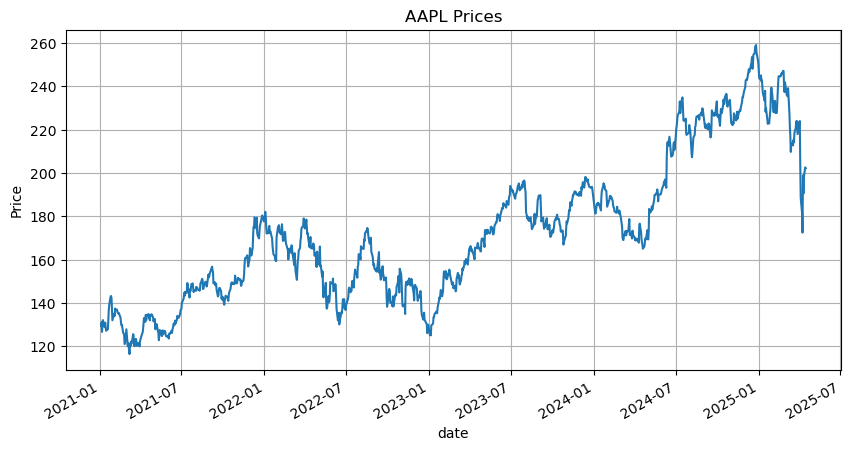

In [8]:
prices['AAPL'].plot(title="AAPL Prices", ylabel="Price", figsize=(10, 5))
plt.grid(True)
plt.show()


In [9]:
factor

date        ticker
2021-01-07  A          0.751427
            AA         1.269183
            AAL        9.116057
            AAOI       3.036817
            AAON       1.083181
                        ...    
2025-04-15  ZS         0.142759
            ZTS        0.393510
            ZUMZ       1.868745
            ZYME       3.218683
            ZYXI      10.419500
Name: factor_price_compression, Length: 2757610, dtype: float64

In [10]:
df2 = handler.get_data(date="2025-04-15", lookback=2000, columns = ['close', 'volume', 'transactions'])

In [11]:
# Ensure prices.index is datetime, timezone-naive, and normalized
df2.index = pd.to_datetime(df2.index).tz_localize(None).normalize()

In [12]:
# Pivot to wide format
volume_df = df2.pivot(index='date', columns='ticker', values='volume').sort_index()
transactions_df = df2.pivot(index='date', columns='ticker', values='transactions').sort_index()

In [14]:
# Clean factor index (ensure tz-naive)
factor.index = pd.MultiIndex.from_tuples(
    [(pd.to_datetime(d).tz_localize(None), t) for d, t in factor.index],
    names=["date", "ticker"]
)

In [15]:
# 1. Get the shared (date, ticker) index between both factors
shared_index = factor.index.intersection(factor.index)

# 2. Trim both factors to that shared index
factor = factor.loc[shared_index]
factor_2 = factor_2.loc[shared_index]


In [16]:
factor_2


date        ticker
2021-01-07  A          85.105345
            AA        155.431947
            AAL       323.206041
            AAOI      147.100352
            AAON       94.860878
                         ...    
2025-04-15  ZS         59.702234
            ZTS        63.637966
            ZUMZ       55.854820
            ZYME       91.702882
            ZYXI       77.616802
Name: factor_vpt_vol, Length: 2757610, dtype: float64

In [17]:
factor

date        ticker
2021-01-07  A          0.751427
            AA         1.269183
            AAL        9.116057
            AAOI       3.036817
            AAON       1.083181
                        ...    
2025-04-15  ZS         0.142759
            ZTS        0.393510
            ZUMZ       1.868745
            ZYME       3.218683
            ZYXI      10.419500
Name: factor_price_compression, Length: 2757610, dtype: float64

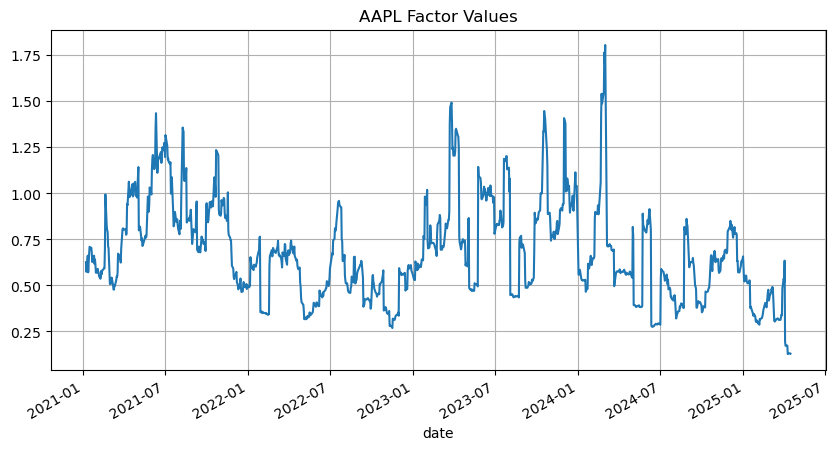

In [18]:
aapl_values = factor.loc[(slice(None), 'AAPL')].sort_index()
aapl_values.plot(title="AAPL Factor Values", figsize=(10, 5))
plt.grid(True)
plt.show()

In [19]:
factor_norm = factor.groupby(level='date').transform(lambda x: (x - x.mean()) / x.std())
factor_2_norm = factor_2.groupby(level='date').transform(lambda x: (x - x.mean()) / x.std())

combined_factor = ((0.9 * factor_norm) + (0.1 * factor_2_norm)) / 2
combined_factor.name = "factor_combined"

In [20]:
groups = handler.get_sic_codes()

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min           max          mean           std  \
factor_quantile                                                           
1                1.452495e-07  7.599365e-01  2.905133e-01  1.569134e-01   
2                2.388718e-01  1.342200e+00  7.060351e-01  1.796757e-01   
3                4.451726e-01  2.041295e+00  1.134047e+00  2.583741e-01   
4                7.396878e-01  2.904611e+00  1.653407e+00  3.601632e-01   
5                1.209971e+00  4.048444e+00  2.329579e+00  5.197345e-01   
6                1.679776e+00  5.970463e+00  3.314870e+00  8.048194e-01   
7                2.264768e+00  9.931480e+00  4.935598e+00  1.349243e+00   
8                3.171562e+00  2.032825e+01  8.214648e+00  2.768988e+00   
9                5.043381e+00  7.770170e+15  2.544065e+10  1.404612e+13   

                  count    count %  
factor_quantile                     
1                306020  11.128898  
2                304950  11.089986  
3                305927  11.125516  
4                305033  11.093005  
5                305918  11.125189  
6                304964  11.090495  
7                305996  11.128026  
8                304950  11.089986  
9                306020  11.128898

Returns Analysis


1D      2D      3D
Ann. alpha                                      0.168   0.182   0.187
beta                                           -0.035   0.003   0.023
Mean Period Wise Return Top Quantile (bps)      7.503   8.211   8.482
Mean Period Wise Return Bottom Quantile (bps)  -7.112  -7.151  -6.986
Mean Period Wise Spread (bps)                  14.615  15.354  15.450

<Figure size 640x480 with 0 Axes>

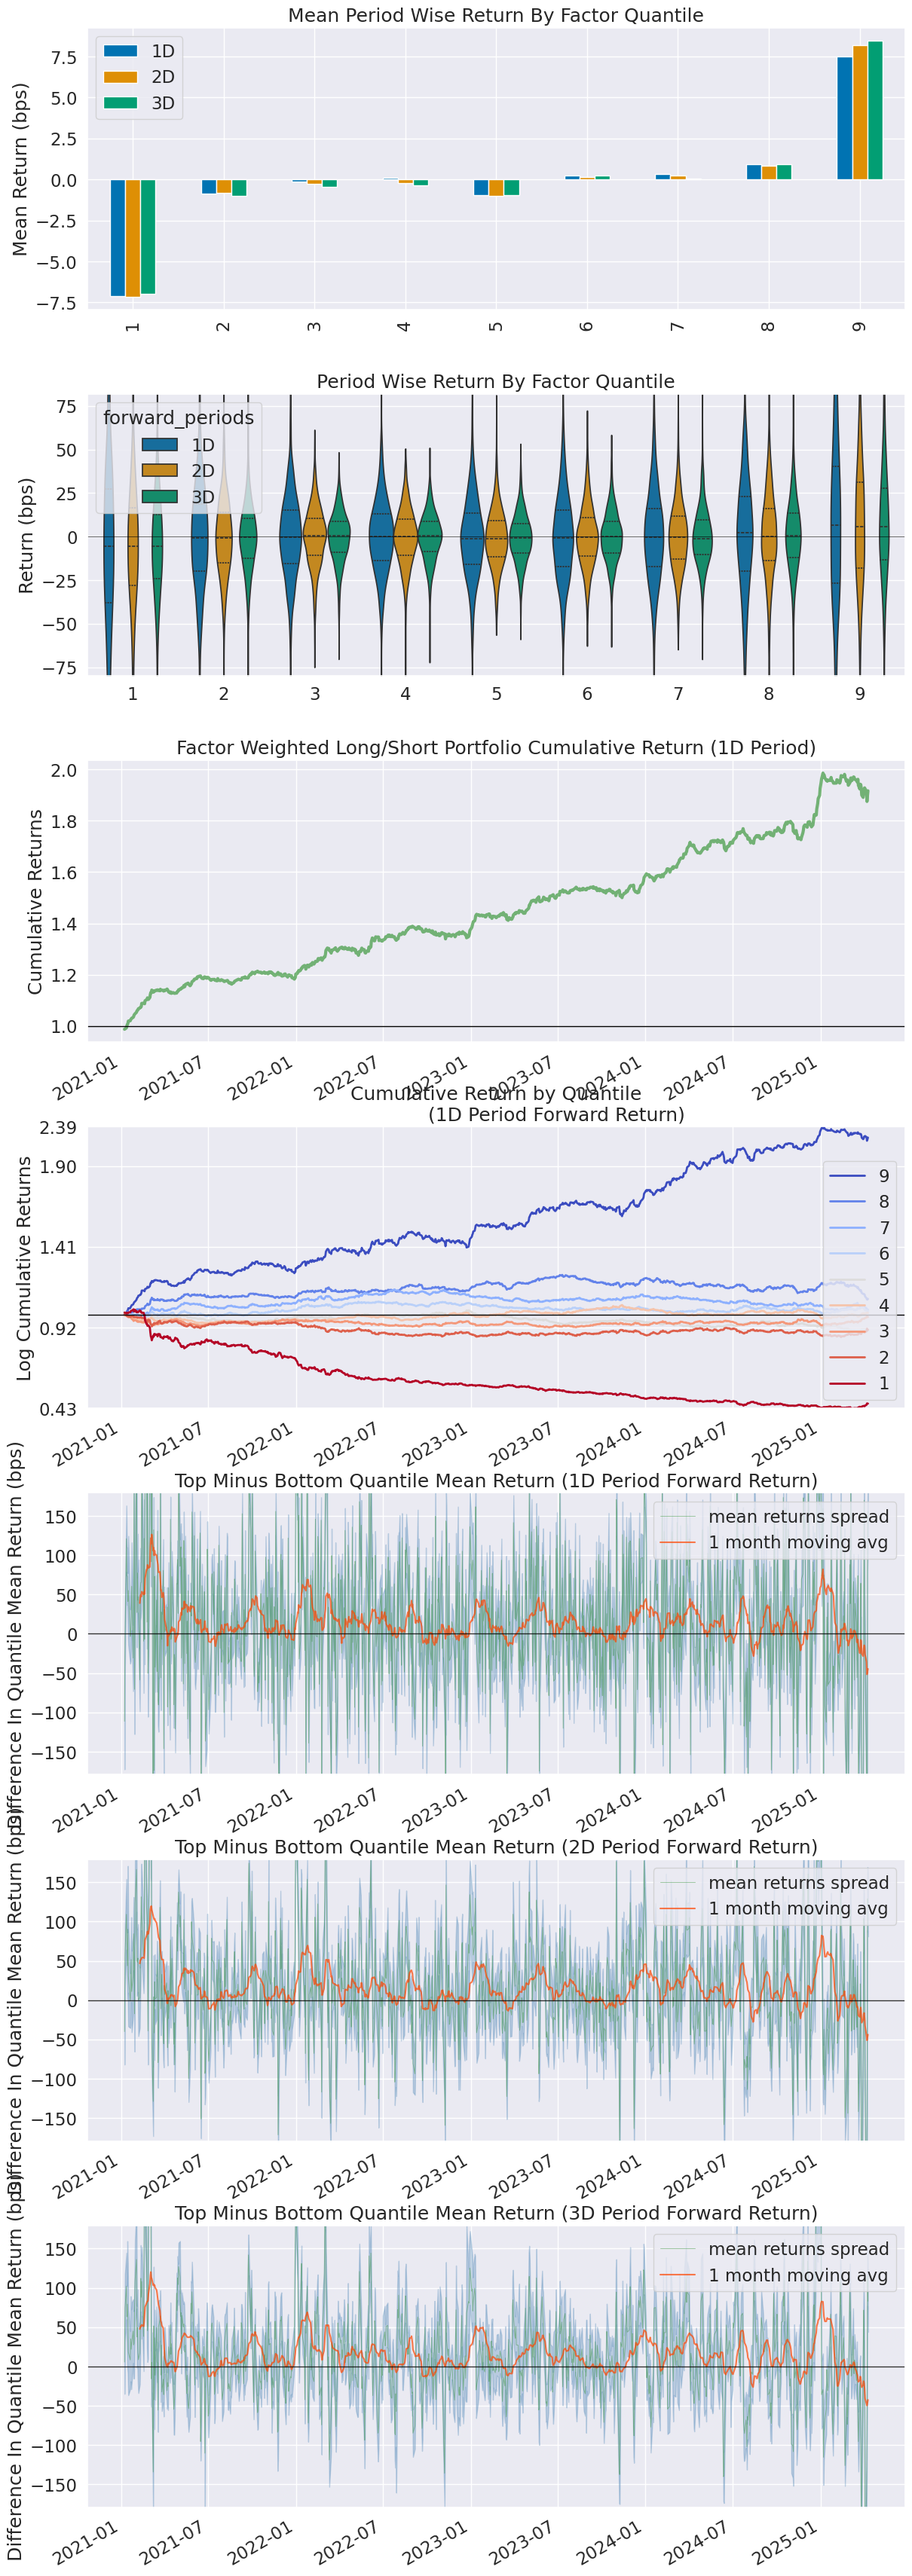

/home/caden/anaconda3/envs/alphactorydb/lib/python3.11/site-packages/alphalens/performance.py:520: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = mean_ret.groupby(grouper).agg(["mean", "std", "count"])
/home/caden/anaconda3/envs/alphactorydb/lib/python3.11/site-packages/alphalens/plotting.py:422: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for a, (sc, cor) in zip(ax, mean_ret_by_q.groupby(level="group")):
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f001a938110>>
Traceback (most recent call last):
  File "/home/c

KeyboardInterrupt: 

In [21]:
import alphalens as al

factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factor,
    prices=prices,
    groupby = groups,
    quantiles=9,
    periods=(1, 2, 3,)
)

al.tears.create_full_tear_sheet(factor_data, by_group=True)

In [22]:
import alphalens.performance as alperf

# Compute mean returns by quantile
mean_ret, std_err = alperf.mean_return_by_quantile(factor_data)

# Calculate the spread between top and bottom quantiles for the 1D period
spread_actual = (mean_ret.loc[5, '1D'] - mean_ret.loc[1, '1D']) * 10000  # Convert to basis points


In [ ]:
import numpy as np
import pandas as pd
import alphalens.utils as alutils
from tqdm import tqdm
num_trials = 1000
mean_spreads_random = []

for _ in tqdm(range(num_trials), desc="Running Permutation Test"):
     # Permute factor within each day
    shuffled_factor = factor.groupby(level='date').transform(np.random.permutation)

    # Get clean factor data
    factor_data_shuffled = alutils.get_clean_factor_and_forward_returns(
        factor=shuffled_factor,
        prices=prices,
        groupby=groups,  # Optional: include if you have group information
        quantiles=5,
        periods=(1, 5, 10)
    )

    # Compute mean returns by quantile
    mean_ret_shuffled, _ = alperf.mean_return_by_quantile(factor_data_shuffled)

    # Calculate the spread between top and bottom quantiles for the 1D period
    spread_bps = (mean_ret_shuffled.loc[5, '1D'] - mean_ret_shuffled.loc[1, '1D']) * 10000
    mean_spreads_random.append(spread_bps)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: your real spread already computed (in bps)
# spread_actual = 25.23  # replace with your actual value

# mean_spreads_random = [...]  # from your permutation loop

plt.figure(figsize=(10, 6))
plt.hist(mean_spreads_random, bins=50, alpha=0.7, label="Permuted Spreads")
plt.axvline(spread_actual, color='red', linestyle='--', linewidth=2, label=f"Actual Spread = {spread_actual:.2f} bps")

plt.title("Monte Carlo Permutation Test: Spread Between Quantiles")
plt.xlabel("Mean Return Spread (bps)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
import vectorbt as vbt

# Step 1: Get quantile bins
quantiles = factor.groupby(level='date').transform(
    lambda x: pd.qcut(x.rank(method='first'), 20, labels=False) + 1  # Labels from 1 to 20
)

# Step 2: Generate long-short weights
weights = (quantiles == 20).astype(int) - (quantiles == 1).astype(int)
weights = weights.unstack()  # Convert to date x ticker

# Normalize cross-sectionally
weights = weights.div(weights.abs().sum(axis=1), axis=0).fillna(0)

# Shift forward to avoid lookahead bias
weights = weights.shift(1).fillna(0)

# Step 3: Align with price data
price_df = prices[weights.columns].loc[weights.index]

# Step 4: Run backtest
portfolio = vbt.Portfolio.from_orders(
    close=price_df,
    size=weights,
    size_type='targetpercent',
    cash_sharing=True,
    freq='1D',
    fees=0.0005,
    init_cash=100000
)


In [ ]:
print(portfolio.stats())


In [ ]:
portfolio.plot().show()


In [ ]:
portfolio.returns().vbt.returns.plot().show()


In [ ]:
portfolio.plot_drawdowns().show()


In [ ]:
portfolio.plot_net_exposure().show()



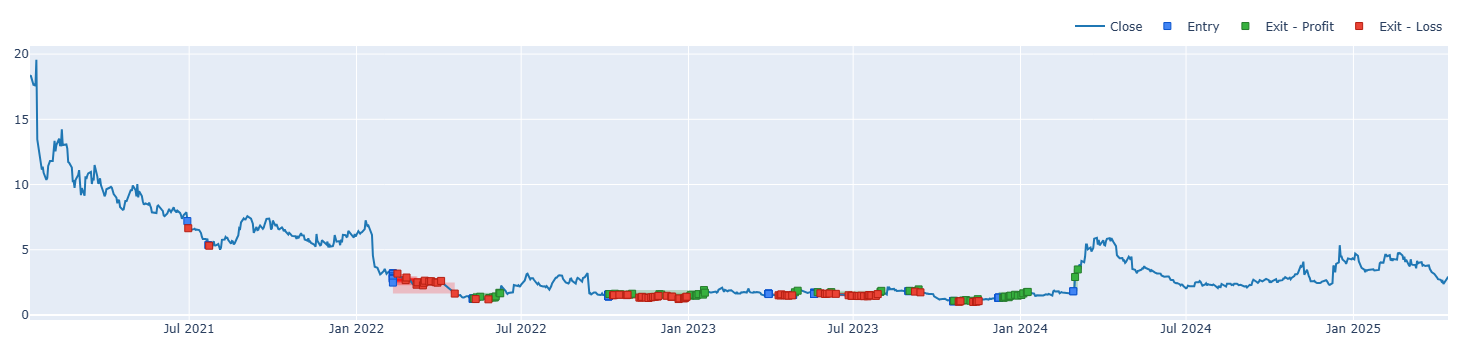

In [29]:
portfolio.plot_trades(column=('CRDF', 'CRDF')).show()

In [ ]:
portfolio.plot_trades(column=('BOOT', 'BOOT')).show()

In [ ]:
portfolio.plot_trades(column=('DASH', 'DASH')).show()

In [ ]:
portfolio.plot_trades(column=('MSFT', 'MSFT')).show()


In [ ]:
portfolio.plot_trades(column=('AAPL', 'AAPL')).show()


In [ ]:
portfolio.plot_underwater().show()


In [ ]:
q_wide = quantiles.unstack()
daily_changes = q_wide.diff().ne(0).sum(axis=1)

import matplotlib.pyplot as plt
daily_changes.plot(title="Quantile Changes Per Day", figsize=(12,4))


In [30]:
portfolio.gross_exposure().max()


8.81356387313836e-14

<Axes: title={'center': 'Sum of Weights per Day'}, xlabel='date'>

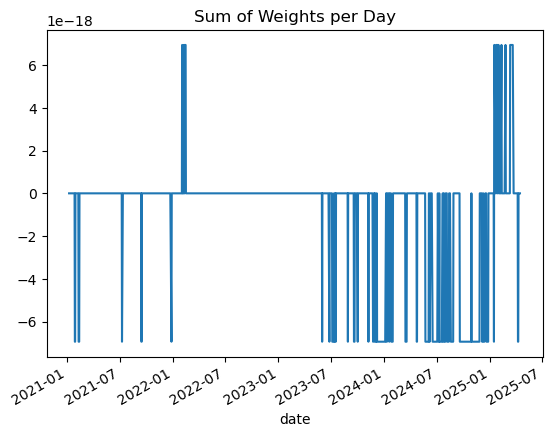

In [31]:
weights.sum(axis=1).plot(title="Sum of Weights per Day")
